# Detección de letras de una imagen: Limpieza de datos y entrenamiento de un modelo

Autores: Alejandro Rasero, Junhao Ge.

### Imports de las librerias necesarias.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import np_utils
import numpy as np
import random
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

%matplotlib inline

### Carga y procesamiento del dataset EMNIST.

In [4]:
ruta = "./DatasetLetrasEmnist"

data_train = pd.read_csv(ruta+'/emnist-letters-train.csv', sep=',')
data_train.columns = ['label'] + [str(i) for i in range(784)]
data_train

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88794,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88795,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88796,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88797,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
data_train['label'].value_counts()

25    3453
11    3438
5     3437
24    3437
20    3436
17    3435
16    3430
9     3428
26    3427
8     3424
22    3422
23    3422
21    3419
3     3419
18    3419
12    3415
15    3408
10    3402
13    3402
4     3398
2     3396
1     3396
6     3394
19    3392
7     3385
14    3365
Name: label, dtype: int64

Visualizamos algunas imágenes de entrenamiento y vemos que es necesario rotaras para colocarlas en su posicion correcta.

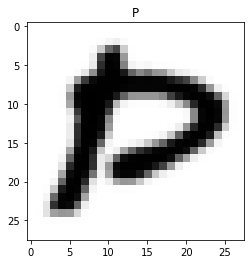

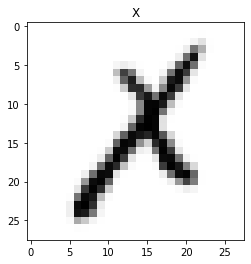

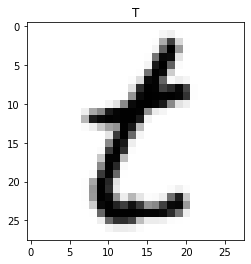

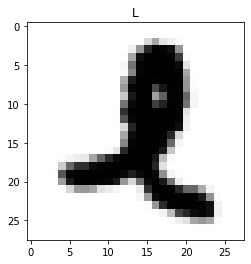

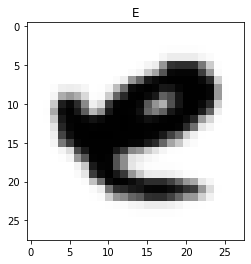

In [3]:
for i in range(5):
    index_train = random.randint(0, len(data_train))
    aux_train = np.flipud(np.rot90(data_train.iloc[index_train, 1:].to_numpy().reshape(28,28)))
    label_train = data_train.loc[index_train][0]
    
    a = aux_train
    
    plt.imshow(aux_train.astype('float64'), cmap='Greys')
    plt.title(chr(label_train + 64))
    plt.show()

Realizamos el mismo proceso para los datos de test.

In [4]:
data_test = pd.read_csv(ruta+'/emnist-letters-test.csv', sep=',')
data_test.columns = ['label'] + [str(i) for i in range(784)]
data_test

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14794,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14795,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14796,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14797,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


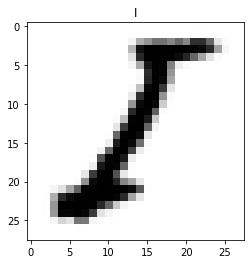

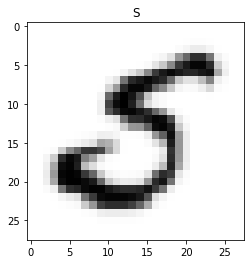

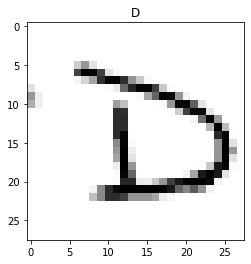

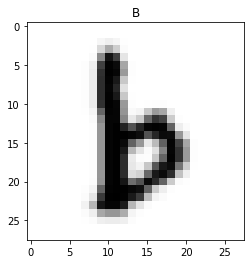

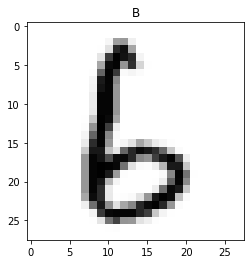

In [5]:
for i in range(5):
    index_test = random.randint(0, len(data_test))
    aux_test = np.flipud(np.rot90(data_test.iloc[index_test, 1:].to_numpy().reshape(28,28)))
    label_test = data_test.loc[index_test][0]

    plt.imshow(aux_test.astype('float64'), cmap='Greys')
    plt.title(chr(label_test + 64))
    plt.show()

En este punto nos damos cuenta que hay letras que no se encuentran presentes en el dataset de testeo. Por ello, extraeremos imágenes de estas letras de los datos de entrenamiento y se las pasaremos a los datos de test.

In [6]:
len(set(data_test['label'].values)), len(set(data_train['label'].values))

(19, 26)

In [7]:
data_train_aux = data_train 
data_test_aux = data_test

faltan = []

for letter in set(data_train_aux['label'].values):
    if not letter in set(data_test_aux['label'].values):
        faltan.append(letter)

total = 0
borrar = np.array([])

for elem in faltan:
    print("Extrayendo imagenes correspondientes a la etiqueta:", elem)
    tamaño = len(data_train_aux.loc[data_train_aux['label'] == elem].index)
    indices = np.array(data_train_aux[data_train_aux['label'] == elem].index).tolist()
    
    train = np.array(random.sample(indices, int(tamaño*0.2)))
    
    borrar = np.append(borrar, train)
    print("Se van a transpasar", len(train), "imágenes\n")
    
    cambio = data_train_aux.iloc[train]
    
    total += len(train)
    
    data_test_aux = data_test_aux.append(pd.DataFrame(cambio), ignore_index=True)

data_train_aux = data_train_aux.drop(borrar)

print("Total imagenes transpasadas de train a test: ", total)

data_train = data_train_aux
data_test = data_test_aux

Extrayendo imagenes correspondientes a la etiqueta: 20
Se van a transpasar 687 imágenes



C:\Users\Alejandro\AppData\Local\Temp\ipykernel_3504\2690794602.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_test_aux = data_test_aux.append(pd.DataFrame(cambio), ignore_index=True)


Extrayendo imagenes correspondientes a la etiqueta: 21
Se van a transpasar 683 imágenes

Extrayendo imagenes correspondientes a la etiqueta: 22
Se van a transpasar 684 imágenes

Extrayendo imagenes correspondientes a la etiqueta: 23
Se van a transpasar 684 imágenes

Extrayendo imagenes correspondientes a la etiqueta: 24
Se van a transpasar 687 imágenes

Extrayendo imagenes correspondientes a la etiqueta: 25
Se van a transpasar 690 imágenes

Extrayendo imagenes correspondientes a la etiqueta: 26
Se van a transpasar 685 imágenes

Total imagenes transpasadas de train a test:  4800


A continuación tratamos el problema antes mencionado sobre la orientación de las imágenes.

In [8]:
images = []
labels = []
for i in tqdm(range(len(data_train))):
    image = np.flipud(np.rot90(data_train.iloc[i, 1:].to_numpy().reshape(28,28)))
    images.append(image)
    label = data_train.iloc[i, 0]
    labels.append(label)
X_train = np.array(images)
y_train = np.array(labels)
y_train = y_train - 1

100%|██████████████████████████████████████████████████████████████████████████| 83999/83999 [00:20<00:00, 4167.54it/s]


In [9]:
images = []
labels = []

for i in tqdm(range(len(data_test))):
    image = np.flipud(np.rot90(data_test.iloc[i, 1:].to_numpy().reshape(28,28)))
    images.append(image)
    label = data_test.iloc[i, 0]
    labels.append(label)
X_test = np.array(images)
y_test = np.array(labels)
y_test = y_test - 1

100%|██████████████████████████████████████████████████████████████████████████| 19599/19599 [00:03<00:00, 5080.70it/s]


### Carga y procesamiento del dataset Digital Letters

In [5]:
df_train = pd.read_csv(ruta+'/digital_letters.csv', sep=',', encoding='utf-8', index_col=0)
df_train

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,V
13126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
13127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X
13128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Y


In [9]:
df_test = pd.read_csv(ruta+'/digital_letters_alt.csv', sep=',', encoding='utf-8', index_col=0)
df_test

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,D
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,V
7796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W
7797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,X
7798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Y


In [11]:
df_test['label'].value_counts()

A    300
B    300
Y    300
X    300
W    300
V    300
U    300
T    300
S    300
R    300
Q    300
P    300
O    300
N    300
M    300
L    300
K    300
J    300
I    300
H    300
G    300
F    300
E    300
D    300
C    300
Z    300
Name: label, dtype: int64

Es necesario codificar la etiquetas en forma numérica para que estos datos sean legibles por los posteriores modelos que empleemos.

In [12]:
df_train['label'] = df_train['label'].astype('category')
df_train['label'] = df_train['label'].cat.codes
df_train['label'] = df_train['label']

df_test['label'] = df_test['label'].astype('category')
df_test['label'] = df_test['label'].cat.codes
df_test['label'] = df_test['label']

Juntamos todos los datos, creando los conjuntos finales de entrenamiento y testeo.

In [13]:
data_train_digital = df_train.drop(columns=['label']).values
data_test_digital = df_test.drop(columns=['label']).values

label_train_digital = df_train['label'].values
label_test_digital = df_test['label'].values

X_train_aux = np.concatenate((X_train, data_train_digital.reshape(len(data_train_digital), 28, 28)), axis=0)
y_train_aux = np.concatenate((y_train, label_train_digital), axis=0) 

X_test_aux = np.concatenate((X_test, data_test_digital.reshape(len(data_test_digital), 28, 28)), axis=0)
y_test_aux = np.concatenate((y_test, label_test_digital), axis=0)

X_train = X_train_aux
y_train = y_train_aux
X_test = X_test_aux
y_test = y_test_aux

In [15]:
print("Shape de X_train: ", X_train.shape)
print("Shape de Y_train: ", y_train.shape)
print("Shape de X_test: ", X_test.shape)
print("Shape de Y_test: ", y_test.shape)

Shape de X_train:  (97129, 28, 28)
Shape de Y_train:  (97129,)
Shape de X_test:  (27399, 28, 28)
Shape de Y_test:  (27399,)


In [16]:
valores_unicos, frecuencias = np.unique(y_train, return_counts=True)

# Muestra los resultados
for valor, frecuencia in zip(valores_unicos, frecuencias):
    print(f"Valor: {valor}, Frecuencia: {frecuencia}")

Valor: 0, Frecuencia: 3901
Valor: 1, Frecuencia: 3901
Valor: 2, Frecuencia: 3924
Valor: 3, Frecuencia: 3903
Valor: 4, Frecuencia: 3942
Valor: 5, Frecuencia: 3899
Valor: 6, Frecuencia: 3890
Valor: 7, Frecuencia: 3929
Valor: 8, Frecuencia: 3933
Valor: 9, Frecuencia: 3907
Valor: 10, Frecuencia: 3943
Valor: 11, Frecuencia: 3920
Valor: 12, Frecuencia: 3907
Valor: 13, Frecuencia: 3870
Valor: 14, Frecuencia: 3913
Valor: 15, Frecuencia: 3935
Valor: 16, Frecuencia: 3940
Valor: 17, Frecuencia: 3924
Valor: 18, Frecuencia: 3897
Valor: 19, Frecuencia: 3254
Valor: 20, Frecuencia: 3241
Valor: 21, Frecuencia: 3243
Valor: 22, Frecuencia: 3243
Valor: 23, Frecuencia: 3255
Valor: 24, Frecuencia: 3268
Valor: 25, Frecuencia: 3247


In [17]:
valores_unicos, frecuencias = np.unique(y_test, return_counts=True)

# Muestra los resultados
for valor, frecuencia in zip(valores_unicos, frecuencias):
    print(f"Valor: {valor}, Frecuencia: {frecuencia}")

Valor: 0, Frecuencia: 1099
Valor: 1, Frecuencia: 1100
Valor: 2, Frecuencia: 1100
Valor: 3, Frecuencia: 1100
Valor: 4, Frecuencia: 1100
Valor: 5, Frecuencia: 1100
Valor: 6, Frecuencia: 1100
Valor: 7, Frecuencia: 1100
Valor: 8, Frecuencia: 1100
Valor: 9, Frecuencia: 1100
Valor: 10, Frecuencia: 1100
Valor: 11, Frecuencia: 1100
Valor: 12, Frecuencia: 1100
Valor: 13, Frecuencia: 1100
Valor: 14, Frecuencia: 1100
Valor: 15, Frecuencia: 1100
Valor: 16, Frecuencia: 1100
Valor: 17, Frecuencia: 1100
Valor: 18, Frecuencia: 700
Valor: 19, Frecuencia: 987
Valor: 20, Frecuencia: 983
Valor: 21, Frecuencia: 984
Valor: 22, Frecuencia: 984
Valor: 23, Frecuencia: 987
Valor: 24, Frecuencia: 990
Valor: 25, Frecuencia: 985


In [18]:
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = (X_train > 0.4).astype(int)
X_test = (X_test > 0.4).astype(int)

indices_aleatorios_train = np.arange(len(X_train))
np.random.shuffle(indices_aleatorios_train)

X_train = X_train[indices_aleatorios_train]
y_train = y_train[indices_aleatorios_train]

indices_aleatorios_test = np.arange(len(X_test))
np.random.shuffle(indices_aleatorios_test)

X_test = X_test[indices_aleatorios_test]
y_test = y_test[indices_aleatorios_test]

Visualización de las imágenes finales.

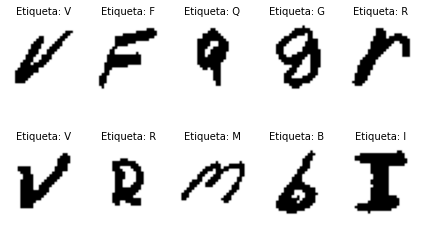

In [19]:
indices_aleatorios = random.sample(range(len(X_train)), 10)

for j, i in enumerate(indices_aleatorios, 1):
    plt.subplot(2, 5, j)
    etiqueta = chr(y_train[i] + 65)
        
    plt.imshow(X_train[i], cmap='Greys')
    plt.title(f'Etiqueta: {etiqueta}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Entrenamiento de modelos

In [20]:
def plot(h):
    LOSS = 0; ACCURACY = 1
    training = np.zeros((2,EPOCHS)); testing = np.zeros((2,EPOCHS))
    training[LOSS] = h.history['loss']
    testing[LOSS] = h.history['val_loss']
    training[ACCURACY] = h.history['accuracy']
    testing[ACCURACY] = h.history['val_accuracy']

    epochs = range(1,EPOCHS+1)
    fig, axs = plt.subplots(1,2, figsize=(17,5))
    for i, label in zip((LOSS, ACCURACY),('loss', 'accuracy')):   
        axs[i].plot(epochs, training[i], 'b-', label='Training ' + label)
        axs[i].plot(epochs, testing[i], 'y-', label='Test ' + label)
        axs[i].set_title('Training and test ' + label)
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(label)
        axs[i].legend()
    plt.show()

In [21]:
clases = len(set(y_train))
input_size = (28, 28, 1)
EPOCHS = 10
batch_size = 256

y_train_categorical = np_utils.to_categorical(y_train, clases) # Pasamos a one-hot encoding
y_test_categorical = np_utils.to_categorical(y_test, clases) # Pasamos a one-hot encoding

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_354 (Conv2D)         (None, 24, 24, 32)        832       
                                                                 
 batch_normalization_296 (Ba  (None, 24, 24, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_355 (Conv2D)         (None, 24, 24, 32)        25632     
                                                                 
 batch_normalization_297 (Ba  (None, 24, 24, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_356 (Conv2D)         (None, 12, 12, 64)        51264     
                                                                 
 batch_normalization_298 (Ba  (None, 12, 12, 64)     

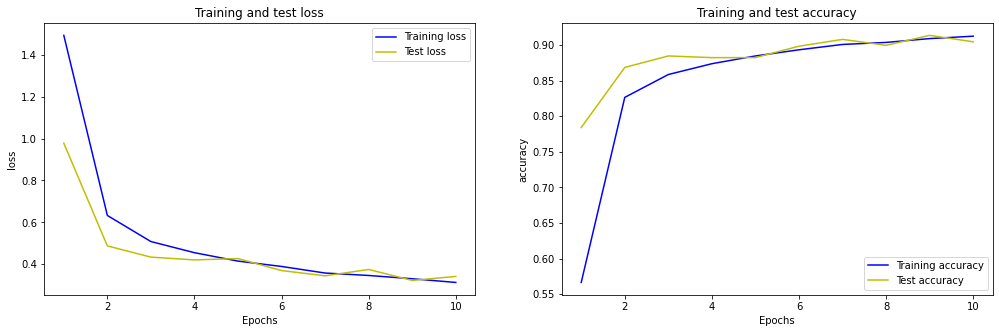

In [139]:
model = Sequential()

model.add(Conv2D(32, kernel_size = 5, activation='relu', input_shape = (input_size[0], input_size[1], input_size[2])))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size = 5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = 5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size = 5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size = 3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = 3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size = 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size = 3, activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(clases, activation='softmax'))

modelo8 = model
modelo8.summary()

modelo8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = modelo8.fit(X_train, y_train_categorical, validation_data=(X_test, y_test_categorical), epochs=EPOCHS, batch_size=batch_size, verbose=1)
plot(history)

Guardamos el modelo para tenerlo disponible posteriormente

In [ ]:
# model.save('./modelos/modelo_OCR_Simple_8.h5')